# Gradient Bandit Algorithms

Another way to select actions is to learn a numerical preference for each action $a$, which we denote $H_t(a)$. It has no interpretation in terms of reward. Only the relative preference of one action over another is important.

Let $\pi_t(a)$ be the probability of taking an action $a$ in time step $t$:

$$
\pi_t(a) = P(A_t = a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}
$$

Initially all action preferences are the same (e.g. $H_1(a)=0$, for all $a$) so that all actions have an equal probability of being selected.

A natural learning algorithm for this setting is stochastic gradient ascent. Each action preference $H_t(a)$ would be incremented proportional to the increment's effect on performance:

$$
H_{t+1}(a) = H_t(a) + \alpha\frac{\partial \mathbb E[R_t]}{\partial H_t(a)}
$$

where the measure of performance here is the expected reward:

$$
\mathbb E[R_t] = \sum_x \pi_t(x) q_*(x)
$$

and the measure of the increment's effect is the partial derivative of this performance measure with respect to the action preference. 

We have

$$
\begin{align*}
\frac{\partial \mathbb E[R_t]}{\partial H_t(a)} 
&= \frac{\partial}{\partial H_t(a)} \left( \sum_x \pi_t(x) q_*(x) \right)
\\
&= \sum_x q_*(x)\frac{\partial \pi_t(x)}{\partial H_t(a)}
\\
&= \sum_x(q_*(x) - B_t)\frac{\partial \pi_t(x)}{\partial H_t(a)}
\end{align*}
$$

for the baseline $B_t$ that does not depend on $x$. We can include a baseilne here without changing the equality. This is possible because the sum of gradients over all the actions is always zero.

Wrangling the above equation further, we have

$$
\frac{\partial \mathbb E[R_t]}{\partial H_t(a)} = \sum_x \pi_t(x)(q_*(x) - B_t)\frac{\partial \pi_t(x)}{\partial H_t(a)}/\pi_t(x)
$$

which makes the above equation in the form of an expectation summing over all possible values $x$ of the random variable $A_t$:

$$
\begin{align*}
\frac{\partial \mathbb E[R_t]}{\partial H_t(a)} 
&= \mathbb E\left[ (q_*(A_t) - B_t)\frac{\partial \pi_t(A_t)}{\partial H_t(a)} / \pi_t(A_t) \right]
\\
&= \mathbb E\left[ (R_t - \bar R_t)\frac{\partial \pi_t(A_t)}{\partial H_t(a)}  / \pi_t(A_t)\right]
\end{align*}
$$

where we chose the baseline $B_t = \bar R_t$ and substituted q_*(A_t) with $R_t$ as we have $\mathbb E\left[ R_t\mid A_t \right]=q_*(A_t)$. Moreover, we have

$$
\begin{align*}
\frac{\partial \pi_t(x)}{\partial H_t(a)} 
&= \frac{\partial}{\partial H_t(a)}\pi_t(x)
\\
&= \frac{\partial}{\partial H_t(a)}\left( \frac{e^{H_t(x)}}{\sum_{y=1}^k e^{H_t(y)}} \right)
\\
&= \frac{\frac{\partial e^{H_t(x)}}{\partial H_t(a)}\sum_{y=1}^k e^{H_t(y)} - e^{H_t(x)}\frac{\partial \sum_{y=1}^k e^{H_t(y)}}{\partial H_t(a)}}{\left( \sum_{y=1}^k e^{H_t(y)} \right)^2}
\\
&= \frac{ 1_{a=x}e^{H_t(x)}\sum_{y=1}^k e^{H_t(y)} - e^{H_t(x)}e^{H_t(a)} }{\left( \sum_{y=1}^k e^{H_t(y)} \right)^2}
\\
&= \frac{ 1_{a=x}e^{H_t(x)}}{\sum_{y=1}^k e^{H_t(y)}} - \frac{e^{H_t(x)}e^{H_t(a)}}{\left( \sum_{y=1}^k e^{H_t(y)} \right)^2}
\\
&= 1_{a=x}\pi_t(x) - \pi_t(x)\pi_t(a)
\\
&= \pi_t(x)( 1_{a=x} - \pi_t(a))
\end{align*}
$$

and have

$$
\begin{align*}
\frac{\partial \mathbb E[R_t]}{\partial H_t(a)}  
&= \mathbb E\left[ (R_t - \bar R_t) \pi_t(A_t) (1_{a=A_t} - \pi_t(a)) / \pi_t(A_t) \right]
\\
&= \mathbb E\left[ (R_t - \bar R_t)(1_{a=A_t} - \pi_t(a)) \right]
\end{align*}
$$


Therefore, on each step, after selecting action $A_t$ and receiving the reward $R_t$, the action preferences are updated by:

$$
\begin{align*}
H_{t+1}(a) 
&= H_t(a) + \alpha(R_t - \bar R_t)( 1_{a=A_t} - \pi_t(a))
\\
&=
\begin{cases}
H_t(a) + \alpha(R_t - \bar R_t)(1- \pi_t(a)) &\text{if }a = A_t
\\
H_t(a) - \alpha(R_t - \bar R_t)\pi_t(a) &\text{otherwise}
\end{cases}
\end{align*}
$$

where $\alpha > 0$ is a step-size parameter and $\bar R_t \in \mathbb R$ is the average of all the rewards up to time $t$. We compare the reward with the baseline $\bar R_t$. If the reward is higher than the baseline, then the probability of taking $A_t$ in the future is increased, and if the reward is below baseline, then probability is decreased. The non-selected actions move in the opposite direction.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_episodes = 2000
n_timesteps = 1000
k = 10
alpha = 0.1

In [3]:
def softmax(x):
    return np.exp(x) / sum(np.exp(x))


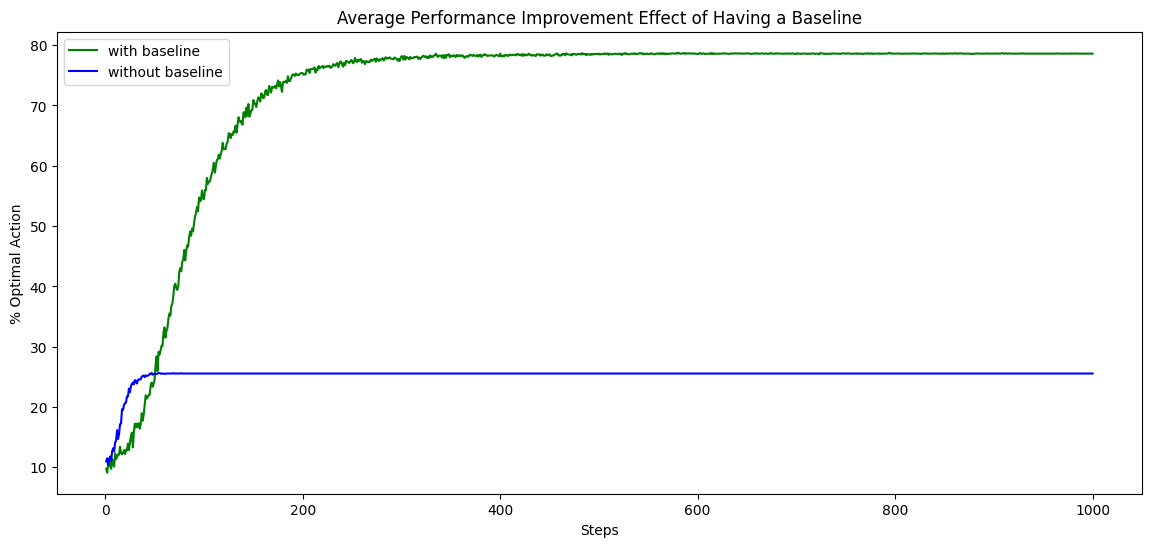

In [4]:
history = [[[0 for _ in range(n_timesteps)] for _ in range(n_episodes)] for _ in range(2)]

# for episode in range(1):
for episode in range(n_episodes):
    q_star = [np.random.normal(4, 1) for _ in range(k)]
    optimal_action = np.argmax(q_star)
    preference = [[0 for _ in range(k)] for _ in range(2)]
    
    # only for i=0
    baseline = 0
    action_count = [0 for _ in range(k)]

    for timestep in range(n_timesteps):       
        # i=0: with baseline, i=1: without baseline
        for i in range(2):
            policy = softmax(preference[i])
            action = np.random.choice(k, p=policy)

            reward = np.random.normal(q_star[action], 1)
            #history_reward[i][episode][timestep] = reward
            
            if action == optimal_action:
                history[i][episode][timestep] = 1
            
            # update baseline
            if i == 0:
                action_count[action] += 1
                baseline += (reward - baseline) / (1+timestep)
                
            for j in range(k):
                if j == action:
                    preference[i][j] += alpha * (reward - (1 - i) * baseline) * (1 - policy[action])
                else:
                    preference[i][j] -= alpha * (reward - (1 - i) * baseline) * policy[action]



avg_optimal_action = np.zeros((2, n_timesteps))
for i in range(2):
    for t in range(n_timesteps):
        avg_optimal_action[i, t] = 100 * np.sum([history[i][episode][t] for episode in range(n_episodes)]) / n_episodes

# Plotting
plt.figure(figsize=(14, 6))
colours = ['green', 'blue']
labels = ['with baseline', 'without baseline']

for i in range(2):
    plt.plot(range(1, n_timesteps + 1), avg_optimal_action[i], color=colours[i], label=labels[i])

plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.title('Average Performance Improvement Effect of Having a Baseline')
plt.legend()
plt.show()